In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
set.seed(9999)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [13]:
df_default <- read_excel('data/default-cc-data.xls')  %>%
    select(-c(X2:X11))%>%
    rename(client_id = "...1", 
           limit_bal = X1,
           sep_bill = X12 , 
           aug_bill= X13 ,
           july_bill= X14,
           june_bill= X15,
           may_bill= X16, 
           april_bill=X17,
           sep_paid= X18 ,
           aug_paid= X19, 
           july_paid= X20, 
           june_paid= X21 ,
           may_paid= X22 ,
           april_paid= X23,
           default_status = Y)%>%
    slice(2:30001) %>%
    mutate_if(is.character, as.numeric) %>%
    mutate(client_id = as.character(client_id),
          default_status = case_when(default_status =="1"~"yes",
                                     default_status== "0"~"no"),
          default_status = as.factor(default_status),
          sep_debt_ratio = sep_bill/limit_bal,
          aug_debt_ratio = aug_bill/limit_bal,
          jul_debt_ratio = july_bill/limit_bal,
          may_debt_ratio = may_bill/limit_bal,
          apr_debt_ratio = april_bill/limit_bal,) %>%
    select(client_id, limit_bal, default_status, sep_debt_ratio : apr_debt_ratio)

head(df_default)

New names:
* `` -> ...1



client_id,limit_bal,default_status,sep_debt_ratio,aug_debt_ratio,jul_debt_ratio,may_debt_ratio,apr_debt_ratio
<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20000,yes,0.1956500,0.1551000,0.0344500,0.00000000,0.0000000
2,120000,yes,0.0223500,0.0143750,0.0223500,0.02879167,0.0271750
3,90000,no,0.3248778,0.1558556,0.1506556,0.16608889,0.1727667
4,50000,no,0.9398000,0.9646600,0.9858200,0.57918000,0.5909400
5,50000,no,0.1723400,0.1134000,0.7167000,0.38292000,0.3826200
6,50000,no,1.2880000,1.1413800,1.1521600,0.39238000,0.4004800


In [24]:
debt_split = initial_split(df_default, prop = 0.75, strata = default_status)
debt_train = training(debt_split)
debt_test = testing(debt_split)

debt_recipe = recipe(default_status ~ sep_debt_ratio + aug_debt_ratio 
                     + jul_debt_ratio + may_debt_ratio + apr_debt_ratio, data = debt_train)
debt_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

debt_vfold = vfold_cv(debt_train, v=5, strata = default_status)

gridvals = tibble(neighbors = seq(1, 10))

debt_results = workflow() %>%
    add_recipe(debt_recipe) %>%
    add_model(debt_spec) %>%
    tune_grid(resamples = debt_vfold, grid = gridvals)%>%
    collect_metrics()
debt_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6879998,5,0.0024882815,Model01
1,roc_auc,binary,0.5379469,5,0.0031430697,Model01
2,accuracy,binary,0.6896447,5,0.0014688861,Model02
2,roc_auc,binary,0.5583761,5,0.0005955677,Model02
3,accuracy,binary,0.7301331,5,0.0015146580,Model03
3,roc_auc,binary,0.5720985,5,0.0015658977,Model03
4,accuracy,binary,0.7287105,5,0.0035822456,Model04
4,roc_auc,binary,0.5842645,5,0.0023738366,Model04
5,accuracy,binary,0.7437332,5,0.0021281061,Model05


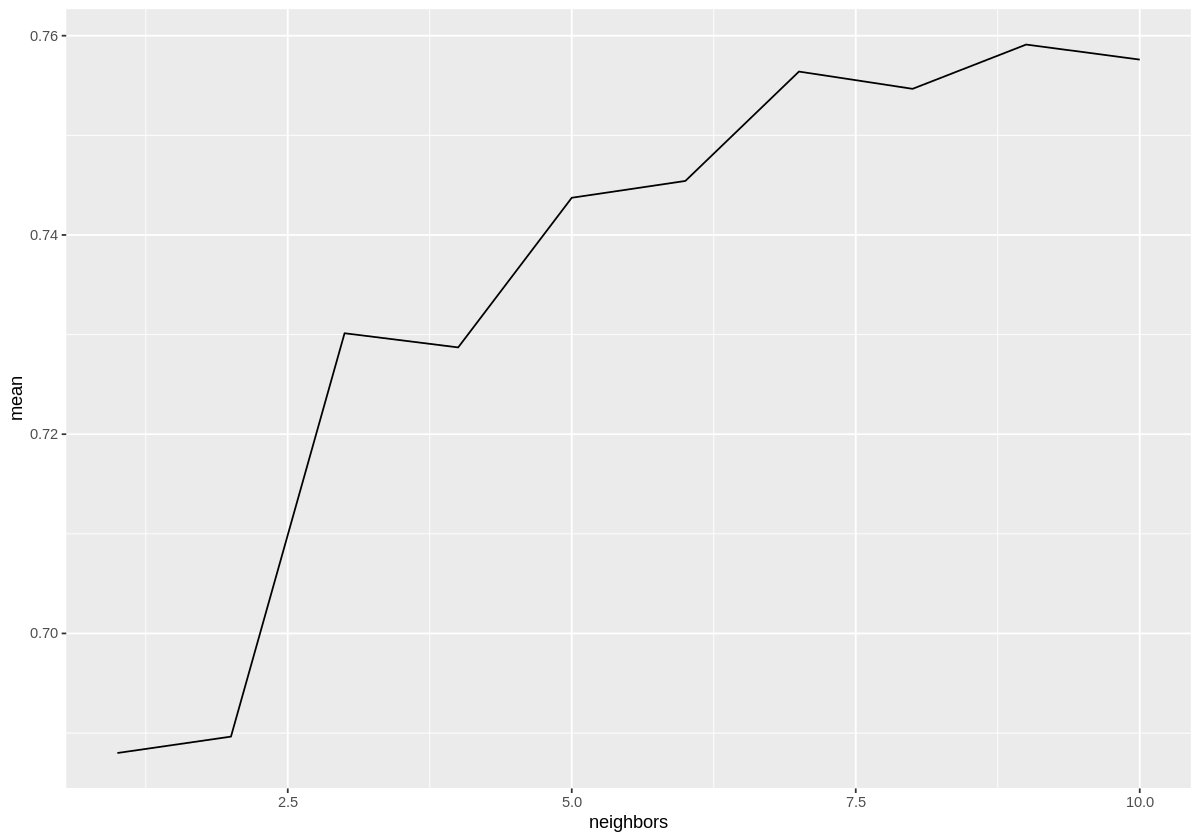

In [29]:
vfold_plot = debt_results %>%
    filter(.metric == "accuracy") %>%
    ggplot(aes(x=neighbors, y=mean)) +
    geom_line()
vfold_plot


In [35]:
final_spec = nearest_neighbor(weight_func = "rectangular", neighbors = 9) %>%
    set_engine("kknn") %>%
    set_mode("classification")

final_fit = workflow() %>%
    add_recipe(debt_recipe) %>%
    add_model(final_spec) %>%
    fit(data = debt_train)
final_fit

debt_test_predictions = predict(final_fit, debt_test) %>%
    bind_cols(debt_test)
debt_test_predictions

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~9, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2432444
Best kernel: rectangular
Best k: 9

.pred_class,client_id,limit_bal,default_status,sep_debt_ratio,aug_debt_ratio,jul_debt_ratio,may_debt_ratio,apr_debt_ratio
<fct>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,3,90000,no,0.3248777778,0.1558555556,0.150655556,0.166088889,0.172766667
no,8,100000,no,0.1187600000,0.0038000000,0.006010000,-0.001590000,0.005670000
no,13,630000,no,0.0192650794,0.0103174603,0.010317460,0.010317460,0.004555556
yes,20,180000,no,0.0000000000,0.0000000000,0.000000000,0.000000000,0.000000000
no,23,70000,yes,0.5869571429,0.6063571429,0.643142857,0.670071429,0.657314286
no,24,450000,yes,0.0122488889,0.0431555556,0.003273333,0.000000000,0.000000000
no,27,60000,yes,-0.0018166667,-0.0070833333,0.004316667,0.002116667,-0.003150000
no,32,50000,yes,0.6103600000,0.5923600000,0.442040000,0.464340000,0.473600000
no,36,160000,no,0.1891562500,-0.0008187500,-0.003293750,-0.009300000,-0.011775000


In [43]:
accuracy = debt_test_predictions %>%
    metrics(truth = default_status, estimate = .pred_class) 

confidence = debt_test_predictions %>%
    conf_mat(truth = default_status, estimate = .pred_class)

accuracy
confidence

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.75653333
kap,binary,0.08736907


          Truth
Prediction   no  yes
       no  5451 1436
       yes  390  223